# Analysis of the single assessment


In [1]:
import os, pickle
import numpy as np
import pandas as pd   # module to work with data in DataFrames.
import seaborn as sns  # module to plot DataFrames in an easy way
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import interpolate

Basic defintion used in the plots. Color, size ...

In [19]:
# seaborn comes with default presets (called 'contents') for figure's aesthetics, 
# such as the font size, figure size etc. 
#sns.set_context('talk') # try: 'talk', 'poster', 'notebook'
sns.set_theme(style="ticks", palette="pastel")

# Set global color scheme for historic and modern images.
sns_palette_historic = ["m"]
sns_palette_modern = ["g"]

# Plot size:
sns_plot_size = (11.7, 8.27)

## Get the result files

In [20]:
single_result_dir = Path('../single_assessment/results').absolute()
single_result_file_names = os.listdir(single_result_dir)
single_result_file_names = list(filter(lambda name: str.startswith(name, 'result'), single_result_file_names))

single_result_files_paths = []
for name in single_result_file_names:
    single_result_files_paths.append(single_result_dir / name)

print(f"Number observer: {len(single_result_files_paths)}")

Number observer: 24


Write result files to dataframe.

In [21]:
df = pd.DataFrame()
for index, path in enumerate(single_result_files_paths):
    df_tmp = pd.read_csv(path)
    df_tmp['observer'] = index
    df = pd.concat((df, df_tmp))


## Sanity checks
We expect 30 historic and 15 modern images used during tests.
Only responses from [0, 9] accepted.

In [5]:
# sanity checks: how many groups do you expect per categorical variable?
assert len(df['test_image'].unique()) == 30 + 15
assert max(df['response'].unique()) <= 9
assert min(df['response'].unique()) >= 0
assert len(df) == (30 + 15) * len(single_result_file_names)
# Check number of observers.
assert len(df['observer'].unique()) == len(single_result_file_names)

## Get average chroma values

In [22]:
with open(Path('../image_generation/02_recolor/average_chroma_values.pkl'), mode='rb') as pkl_file:
    average_chroma_values = pickle.load(pkl_file)

df_average_chroma_values = pd.DataFrame(average_chroma_values)
df_average_chroma_values.columns = ['test_image', 'chroma']

Sanity checks of the average chroma values.

In [7]:
assert len(df_average_chroma_values) == len(df['test_image'].unique())
assert max(df_average_chroma_values['chroma']) <= 100
assert max(df_average_chroma_values['chroma']) >= 0.0

Add the average chroma value for every image to the dataframe.

In [23]:
name = df_average_chroma_values['test_image'].unique()[0]
chroma_list = []
for image in df['test_image']:
    s = df_average_chroma_values.loc[df_average_chroma_values['test_image'] == image, 'chroma']
    chroma_list.append(s.iloc[0])

list(chroma_list)
df['chroma'] = chroma_list

Sanity check added chroma values to the original dataframe.

In [24]:
for row in df.index:
    name = df.loc[df.index == row, 'test_image'].iloc[0]
    test_value = df.loc[df['test_image'] == name, 'chroma'].iloc[0]
    verified_value = df_average_chroma_values.loc[df_average_chroma_values['test_image'] == name, 'chroma'].iloc[0]
    assert np.isclose(test_value, verified_value)

Scale chroma values to [0, 9] range. And assert result.

In [25]:
df['chroma'] = np.array(df['chroma'].tolist()) * (9/100)

assert max(df['chroma']) <= 9
assert min(df['chroma']) >= 0

## Dataframe clean up

Simplify image names: Remove suffix. Sort the dataframe by image name.

In [11]:
df['test_image'] = [s.split('_')[0] for s in df['test_image'].tolist()]
df = df.sort_values(by='test_image', ascending=True, key=lambda col: [int(img[1:]) for img in col])

Devide dataframe into historic and modern images

In [26]:
df_historic = df[df['test_image'].str.startswith('H')]
df_modern = df[df['test_image'].str.startswith('I')]

In [13]:
mean_lists = []
for img_name in df_historic['test_image'].unique():
    mean = np.mean(df_historic.loc[df_historic['test_image'] == img_name, 'response'].tolist())
    chroma = df_historic.loc[df_historic['test_image'] == img_name, 'chroma'].iloc[0]
    mean_lists.append([img_name, mean, chroma])

df_historic_mean = pd.DataFrame(mean_lists)
df_historic_mean.columns = ['test_image', 'mean', 'chroma']
df_historic_mean

,test_image,mean,chroma
0,H0,4.208333,0.587368
1,H1,5.083333,0.450635
2,H2,5.458333,1.080718
3,H3,2.500000,0.428122
4,H4,3.166667,0.632544
5,H5,2.958333,0.464387
6,H6,3.833333,0.287541
7,H7,3.333333,0.826526
8,H8,4.333333,0.559676
9,H9,3.625000,0.647951


In [14]:
#mean_func = interpolate.interp1d(x=np.arange(len(df_historic_mean['mean'])), y=df_historic_mean['mean'])
#chroma_func = interpolate.interp1d(x=np.arange(len(df_historic_mean['chroma'])), y=df_historic_mean['chroma'])

### Historic plots

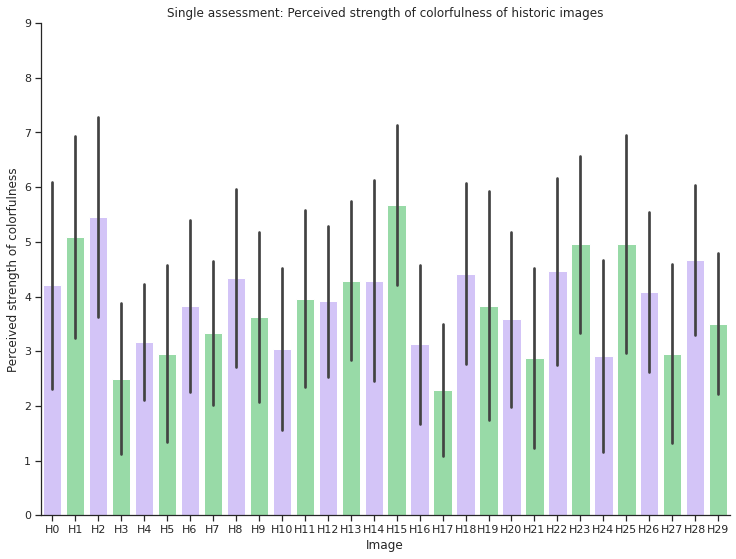

In [15]:
g = sns.catplot(x='test_image', y='response', data=df_historic,
                kind='bar', ci='sd', palette=["m", "g"])



g.set_axis_labels("Image", "Perceived strength of colorfulness")
g.fig.set_size_inches(11.7, 8.27)
g.set(title="Single assessment: Perceived strength of colorfulness of historic images")

g.set(ylim = (0,9))
sns.despine()


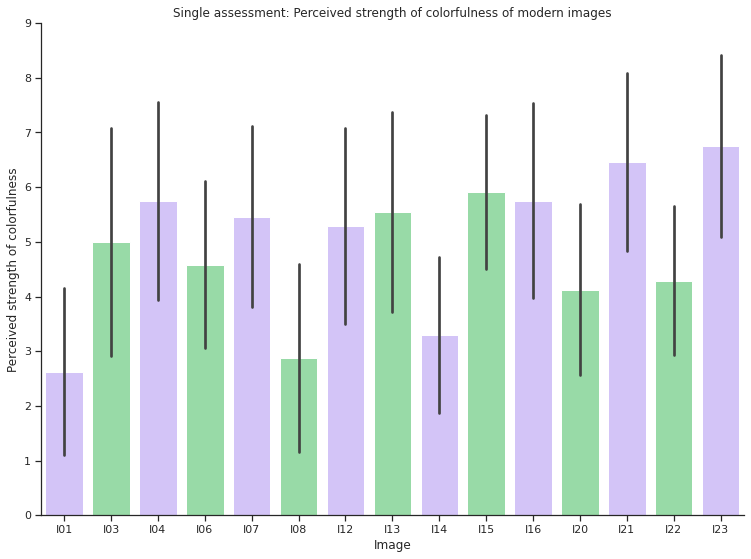

In [16]:
### barplot aggregated by k
## we call the function catplot() (cat: categorical)
#fig, ax = plt.subplots()
#fig, ax = plt.subplots()
# the size of A4 paper
#fig.set_size_inches(11.7, 8.27)
#sns.set(rc={'figure.figsize':(28,10)})

g = sns.catplot(
    x='test_image',
    y='response',
    data=df_modern,
    kind='bar',
    ci='sd',
    #color='#e34a33')
    palette=["m", "g"])

#g.set_xlabel("Image")
#g.set_ylabel("Chroma response")
g.set_axis_labels("Image", "Perceived strength of colorfulness")
g.fig.set_size_inches(11.7, 8.27)
g.set(title="Single assessment: Perceived strength of colorfulness of modern images")

g.set(ylim = (0,9))

In [17]:
### barplot aggregated by g
g = sns.catplot(x='test_image', y='response', data=d, kind='bar', color='#3182bd',
            ci='sd')
g.set_ylabels('Quality')
g.set_xlabels('Gamma')
g.set(ylim = (-3, 3))
#plt.title(current_image)

NameError: name 'd' is not defined

In [ ]:
means = []
for img in df_historic["test_image"].unique():
    means.append((img, "H", np.mean(df_historic[df_historic["test_image"] == img])["response"]))

for img in df_modern["test_image"].unique():
    means.append((img, "I", np.mean(df_modern[df_modern["test_image"] == img])["response"]))
    
df_mean = pd.DataFrame(means)
df_mean.columns = ["test_image", "type", "mean"]
df_mean

,test_image,type,mean
0,H0,H,4.208333
1,H1,H,5.083333
2,H2,H,5.458333
3,H3,H,2.500000
4,H4,H,3.166667
5,H5,H,2.958333
6,H6,H,3.833333
7,H7,H,3.333333
8,H8,H,4.333333
9,H9,H,3.625000


[[Text(0, 0, 'Historic'), Text(1, 0, 'Modern')]]

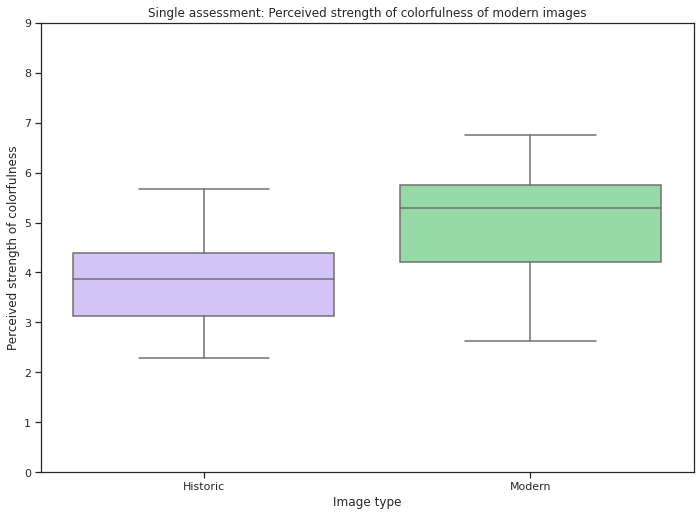

In [ ]:
g = sns.boxplot(x="type", y="mean", palette=["m", "g"], data=df_mean)
#g.set(title="Single assessment: Mean of historic and modern images")
g.figure.set_size_inches(11.7, 8.27)


#g.set_axis_labels("Image type", "Perceived strength of colorfulness")
#g.fig.set_size_inches(11.7, 8.27)
g.set(title="Single assessment: Perceived strength of colorfulness of modern images")

g.set(ylim = (0,9))

#g.set(ylim = (0,max_factor))

#g.set_axis_labels("Image", "Chroma factor")

g.set_xlabel("Image type")
g.set_ylabel("Perceived strength of colorfulness")
#g.set_axis_labels("Image type", "Chroma factor")
#g.set_ylim((0,max_factor))
g.set(xticklabels=["Historic", "Modern"])